# Adaboost for Classification (SAMME)

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.ticker as mtick

Boosting is a widely used *ensemble learning method*. This means that when given a labelled data set, we do not train one strong classifier that seeks to capture the complexities in that data set in its entirety at once, but rather train lots of weak classifiers that might only slightly better than random guessing, and then aggregate them. 

While there are many different types of ensemble learning, in *boosting* the general idea is to train the weak classifiers subsequently. Whenever one weak classifier is trained, we calculate the samples where it is particularly weak and then for the next learner give more weight to those samples where the previous one performed particularly poorly. Finally, you seek to come to an aggregate answer by combining the expertise of many.

# SAMME (Stagewise Additive Modeling using a Multiclass Exponential Loss)
One of the challanges with Adaboost is that while the idea is simple, there is more than one way to concretely implement this idea practically in an algorithm. One very famous example is the SAMME formulation of AdaBoost implemented in [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). We first introduce the notation and explain the algorithm for fitting and prediction and then discuss some details and applications.

## Fitting

**Input:** 
* Labeled dataset $(X,y) = (x_i,y_i)_{i=1, \ldots, N}$, $x_i \in \mathbb{R}^d$, $y_i \in \{1, \ldots, K\}$
* $T \in \mathbb{N}$ the number of weak learners

**Notation:**
We denote by $t=1, \ldots, T$ the index of the weak learner in step $t$. For each step we denote by
* $f_t:\mathbb{R}^n \to \mathbb{R}$ the prediction function of learner $t$
* $w_t \in \mathbb{R}^N$ the vector of weights corresponding to the $N$ samples $x_i$, $i=1, \ldots, N$
* $\alpha_t \in \mathbb{R}$ the weight that learner $t$ will have in the final prediction
* $\varepsilon_t \in \mathbb{R}$ the error of learner $t$


**Steps:** We initialize the weights as uniform, i.e. 
\begin{align*}
    \forall 1 \leq i \leq N: w_{1,i} := \frac{1}{N}.
\end{align*}

For each step $t=1, \ldots, T$, we perform the following tasks:
1. **Train the weak classifier** $t$ on the training set $(X_i, y_i)$, $i=1, \ldots, N$ using the weight vector $w_t$ (see explainations below for more details).
2. Compute the weighted relative **esimator error** of classifier $t$ on the training set:
 \begin{align*}
    \varepsilon_t := \sum_{i=1}^N{w_{t,i}1_{f_t(x_i) \neq y_i}} \in [0,1]
 \end{align*}
3. Compute **estimator weight** for learner $t$:
   \begin{align*}
       \alpha_t := \ln\Big(\frac{1-\varepsilon_t}{\varepsilon_t}\Big) + \ln(K-1)
   \end{align*}
4. Calculate **new weights** for the next step of the iteration:
   \begin{align*}
       \forall 1 \leq i \leq N: \hat w_{t+1,i} := w_{t,i} \exp(\alpha_t 1_{f_t(x_i) \neq y_i)}) && w_{t,i} := \frac{\hat w_i}{\sum_{i=1}^N{\hat w_{t,i}}} \in [0,1].
   \end{align*}

## Prediction
After fitting we can perform prediction on any new datapoint via
\begin{align*}
    F:\mathbb{R}^d \to \mathbb{R} && x \mapsto \operatorname{argmax}_k { \sum_{t=1}^T{\alpha_t 1_{f_t(x)=k}} }
\end{align*}

## Binary case
In tThe binary case $k=2$ one often assumes that the classes are not labeled $\{0,1\}$, but $\{+1, -1\}$ instead. In this case, the class weights need to be halved, i.e. 
\begin{align*}
    \alpha_t = \frac{1}{2}\ln\Big(\frac{1-\varepsilon_t}{\varepsilon_t}\Big)
\end{align*}
and the formulas for weight update and prediction can be compactly re-written as
\begin{align*}
    \hat w_{t+1,i} := w_{t,i} \exp(-\alpha_t y_i f_t(x_i))
\end{align*}
and
\begin{align*}
    F:\mathbb{R}^d \to \mathbb{R} && x \mapsto \operatorname{sgn}\Big( \sum_{t=1}^T{\alpha_t f_t(x)} \Big).
\end{align*}

# Explainations & Illustrations
We discuss the various steps of AdaBoost in more detail. 

## Weak Classifier Training
The first step is to train the weak classifier using the weights. The key point here is that there is more than one way to do that. At least two types of principles can be applied here:
1. **Bootstrap sampling:** Instead of training the classifier on the training data $(x_i, y_i)$, $i=1, \ldots, N$, we instead produce a *bootstrap sample*, i.e. we draw (with replacement) $N$ times at random from the training data, and the probability to draw any given sample $i$ is $w_{t,i}$. This principle has the advantage that it operates only on the data itself, i.e. it is agnostic as to which precise classifier is chosen. It has the disadvantage that the weak classifier is not aware of the weighting and hence cannot take this into account in a way that is somewhat more tailored to the classifier itself.
2. **Train with weights:** Many classifiers have the option of supplying weights to the training process and hence can take them into account in a way that better fits their training process. The precise way of how this is done depends on the classifier.

### Decision Stump Training
At this point one should mention that a very famous use case of this is when the weak learners are [decision stumps](https://en.wikipedia.org/wiki/Decision_stump), i.e. decision trees with a depth of $1$. Decision trees are fitted using an impurity metric, for example the Gini impurity. Recall that in presence of $K$ classes, the Gini impurity of a probability vector $p=(p_1, \ldots, p_K)$, $p_j \geq 0$, $\sum_j{p_k}=1$, is defined by
\begin{align*}
    g(p) := \sum_{k=1}^{K}{p_k(1-p_k)} = 1 - \sum_{k=1}^{K}{p_k^2}
\end{align*}
When calculating the Gini impurity, the values $p_k$ need to be estimated from samples and this is where the weights come in. If no weights are specified, then the estimate is simply given by
\begin{align*}
    \hat p_k := \frac{N_k}{N}, && N_k := |\{i \mid y_i = k\}|.
\end{align*}
In presence of a weight vector $w$, we estimate these as
\begin{align*}
    \hat p_k := \frac{\sum_{j=1}^N{w_j 1_{y_j=k}}}{\sum_{j=1}^K{w_j}}.
\end{align*}
Notice that these estimates coincide for the special case of uniform weights $w_j := \frac{1}{N}$, these estimates coincide. Also notice that the change in which Gini impurity is estimated of course also changes which split is maximizing impurity and hence changes how the tree is fitted.

We quickly validate how weights affect the Gini impurity in ``sklearn.tree.DecisionTreeClassifier''.

In [2]:
# dummy training data
X = np.array([[1], [2], [3], [4], [5]])
y = np.array([0, 0, 1, 1, 1])  # Imbalanced dataset (3 ones, 2 zeros)

# fit without any sample weights (=uniform weights)
clf1 = DecisionTreeClassifier()
clf1.fit(X, y)

# fir with sample weights
sample_weights = np.array([10, 10, 1, 1, 1]) 
clf2 = DecisionTreeClassifier()
clf2.fit(X, y, sample_weight=sample_weights)

DecisionTreeClassifier()

In [3]:
# validate tree calculated impurity is consistent (case 1: without weights)
N = y.shape[0]
p10 = (y==0).sum() / N
p11 = (y==1).sum() / N
gini_impurity1 = 1 - p10**2 - p11**2

np.testing.assert_almost_equal(clf1.tree_.impurity[0], gini_impurity1)

In [4]:
# validate tree calculated impurity is consistent (case 2: with weights)
N = y.shape[0]
p20 = sample_weights[y==0].sum() / sample_weights.sum()
p21 = sample_weights[y==1].sum() / sample_weights.sum()
gini_impurity2 = 1 - p20**2 - p21**2

np.testing.assert_almost_equal(clf2.tree_.impurity[0], gini_impurity2)

## Error and Classifier Weight
Because the sample weights satisfy $w_{t,i} \geq 0$ and $\sum_{i=1}^{N}{w_{w,i}} = 1$ in each step $t$, the error $\varepsilon_t \in [0,1]$ essentially expresses in percent how many classifications are wrong. The dependence of the classifier weight on the error is illustrated below. As we can see, the higher the error the lower the weight and hence the lower the influence of the classifier on the final prediction.

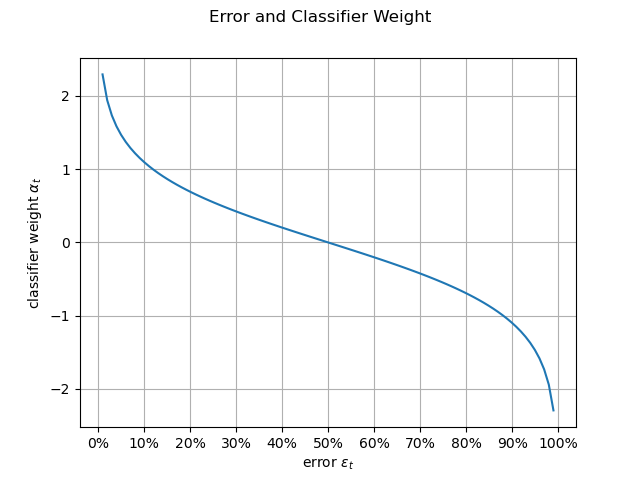

In [5]:
eps = np.linspace(0, 1, 100)[1:-1]

plt.figure()
plt.suptitle('Error and Classifier Weight')
plt.plot(eps, np.log( (1-eps) / eps) / 2)
plt.xlabel('error $\\varepsilon_t$')
plt.ylabel('classifier weight $\\alpha_t$')
plt.locator_params(axis='x', nbins=12)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.show()

## New Weight Calculation
For the new weight calculation it is crucial that in the binary case the two classes are labeled $+1$ and $-1$ and not $1$ and $0$. This is because this ensures that the weak classifier is a map $f_t:\mathbb{R}^d \to \{-1, +1\}$. Hence on a data point $x_i$ a sample is correctly classified if and only if $f_t(x_i)y_i>0$ and incorrectly classified if and only if $f_t(x_i)y_i < 0$. Unless the weak classifier is so bad that more than half of the samples are misclassified, we have $\alpha_t>0$ and thus, if $x_i$ is correctly classified, then 
\begin{align*}
    f_t(x_i)y_i>0 
    && \Longrightarrow &&
    \exp(-\alpha_t y_i f_t(x_i)) < 1 
    && \Longrightarrow &&
    w_{t+1,i} < w_{t,i}
\end{align*}
and analogously, if $x_i$ is incorrectly classified, then
\begin{align*}
    f_t(x_i)y_i<0 
    && \Longrightarrow &&
    \exp(-\alpha_t y_i f_t(x_i)) > 1 
    && \Longrightarrow &&
    w_{t+1,i} > w_{t,i}.
\end{align*}

# Exponential Loss Minimization
One can show that AdaBoost minizes an exponential loss function, which in the case of binary classification has the neat form
\begin{align*}
    \mathcal{L} 
    = \frac{1}{N} \sum_{i=1}^N{\exp(-y_i F(x_i))}
    = \frac{1}{N} \sum_{i=1}^N{\exp\Big(-\sum_{t=1}^T{y_i \alpha_t f_t(x_i)}\Big)}.
\end{align*}
In multi-class classification settings one has to replace this by the multi-class exponential loss
\begin{align*}
    \mathcal{L} 
    = \frac{1}{N} \sum_{i=1}^N{\exp\Big(-\sum_{t=1}^T{ \alpha_t 1_{f_t(x_i)=y_i}}\Big)}.
\end{align*}

# Reconcile Algorithm Idea with Implementation

In [6]:
class AdaBoostSamme:

    def __init__(self):
        self.estimators_ = None
        self.estimator_weights_ = None
        self.estimator_errors_ = None
        self.sample_weights_ = None
        self.estimator_predictions_ = None
        self.exp_loss_history_ = None

    def fit(self, X, y, estimator_type, estimator_params):
    
        n_estimators = len(estimator_params)
        
        # Initialize sample weights uniformly
        n_samples = X.shape[0]
        current_weights = np.full(n_samples, 1 / n_samples)
        
        # store intermediate results for reconciliation
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(n_estimators)
        self.estimator_errors_ = np.zeros(n_estimators)
        self.sample_weights_ = np.zeros((n_estimators, n_samples))
        self.estimator_predictions_ = np.zeros((n_estimators, n_samples))
        self.exp_loss_history_ = np.zeros(n_estimators)
        
        for t in range(n_estimators):
            # log weights
            self.sample_weights_[t,:] = current_weights
            
            # train weak learner using current sample weights
            weak_learner = estimator_type(**estimator_params[t])
            weak_learner.fit(X, y, sample_weight=current_weights)
            self.estimators_.append(weak_learner)
    
            # calculate weighted error
            y_pred = weak_learner.predict(X)
            misclassified = y_pred != y
            error = np.sum(current_weights * misclassified)            
            
            # calculate estimator weight
            alpha = np.log((1 -error) / (error + 1e-10))
                        
            # update sample weights
            current_weights = current_weights * np.exp(alpha * misclassified)
            current_weights /= np.sum(current_weights)  # Normalize to sum to 1

            # log everything
            self.estimator_weights_[t] = alpha
            self.estimator_predictions_[t, :] = y_pred
            self.estimator_errors_[t] = error
    
        # compute exp loss 
        y_conv = np.where(y == 0, -1, 1)
        H_t = np.zeros(n_samples)
        for t, (alpha, estimator) in enumerate(zip(adaboost_custom.estimator_weights_, adaboost_custom.estimators_)):
            y_pred = np.where(estimator.predict(X)==0, -1, 1)
            H_t += alpha * y_pred  # 
            self.exp_loss_history_[t] = np.mean(np.exp(-y_conv * H_t))  # Compute exponential loss

    def predict(self, X):
        pred = np.array([np.where(estimator.predict(X)==0, -1, 1) * alpha 
                         for estimator, alpha in zip(self.estimators_, self.estimator_weights_)])
        return np.where(np.sign(pred.sum(axis=0))==-1,0,1)


In [7]:
# generate synthetic binary classification data
X, y = make_classification(n_samples=500, n_features=10, n_informative=10, n_redundant=0,  class_sep=2.0, random_state=42)

# predict using sklearn AdaBoost
n_estimators = 50
adaboost_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators,
    algorithm='SAMME',
    random_state=42
)
adaboost_sklearn.fit(X, y)
predictions_sklearn = adaboost_sklearn.predict(X)

# predict using custom AdaBoost (SAMME)
estimator_params = [estimator.get_params() for estimator in adaboost_sklearn.estimators_]

adaboost_custom = AdaBoostSamme()
adaboost_custom.fit(X, y, DecisionTreeClassifier, estimator_params)
predictions_custom = adaboost_custom.predict(X)

In [8]:
# reconcile estimator errors
np.testing.assert_array_almost_equal(adaboost_custom.estimator_errors_, adaboost_sklearn.estimator_errors_)

# reconcile estimator weights
np.testing.assert_array_almost_equal(adaboost_custom.estimator_weights_, adaboost_sklearn.estimator_weights_)

# reconcile Gini impurities (indirectly validates that the weights used reconcile)
N = y.shape[0]
gini_impurity_custom = np.zeros(n_estimators)
for t in range(n_estimators):
    p0 = adaboost_custom.sample_weights_[t][y==0].sum()
    p1 = adaboost_custom.sample_weights_[t][y==1].sum()
    gini_impurity_custom[t] = 1 - p0**2 - p1**2
gini_impurity_sklearn = np.array([estimator.tree_.impurity[0] for estimator in adaboost_sklearn.estimators_])
np.testing.assert_array_almost_equal(gini_impurity_custom, gini_impurity_sklearn)

# reconcile predictions
np.testing.assert_array_equal(predictions_sklearn, predictions_custom)

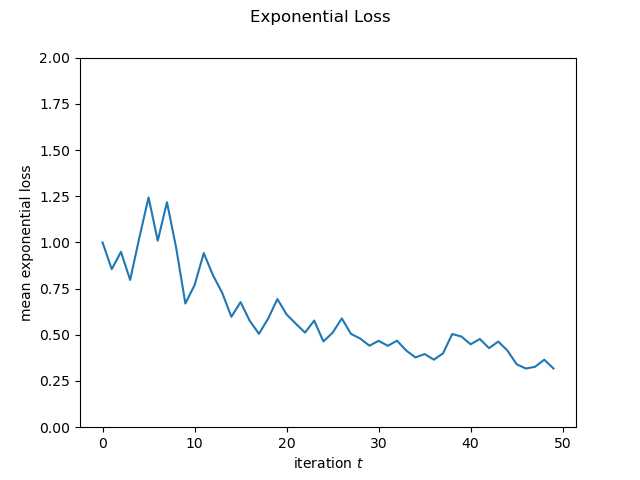

In [9]:
plt.figure()
plt.suptitle('Exponential Loss')
plt.plot(np.arange(n_estimators), adaboost_custom.exp_loss_history_)
plt.xlabel('iteration $t$')
plt.ylabel('mean exponential loss')
plt.ylim(0,2)
plt.show()

In [10]:
# training accuracy
accuracy_score(predictions_custom, y)

0.952

# Example
We illustrate AdaBoost by giving one example of a binary classification task.

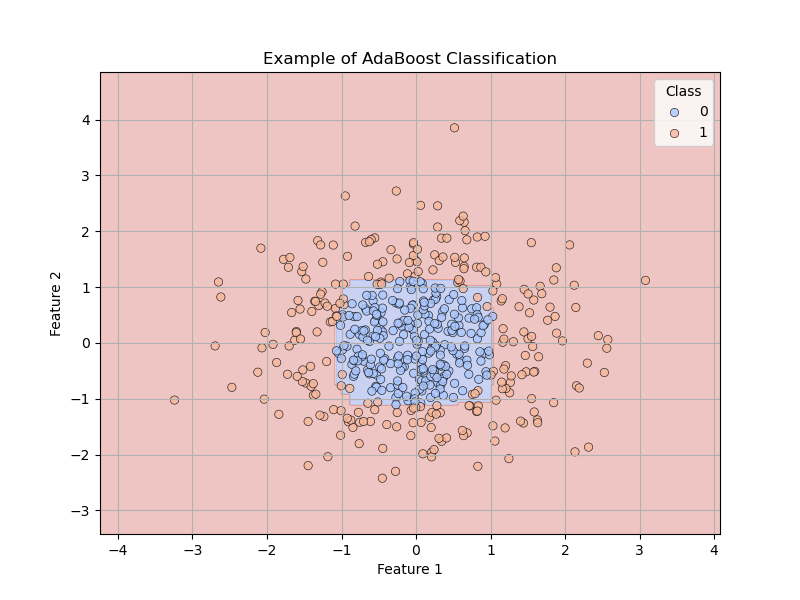

In [12]:
# generate synthetic data set
X, y = make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=2, random_state=42)

# train AdaBoost 
n_estimators = 50
adaboost = AdaBoostClassifier(
    n_estimators=n_estimators,
    algorithm='SAMME',
    random_state=42
)
adaboost.fit(X, y)

# define grid 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict decision boundary over grid
Z = adaboost.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, edgecolor='k', palette='coolwarm', alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Example of AdaBoost Classification")
plt.legend(title="Class")
plt.grid(True)
plt.show()

# References
* [J. Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class adaboost.” Statistics and its Interface 2.3 (2009): 349-360.](https://link.intlpress.com/JDetail/1806634576447516674)
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html